In [9]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('..')
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.preprocessing.two_dim import load_batch_dataset
from tfvpc.preprocessing.two_dim import count_tfrecord_examples
from tfvpc.utils.vis import show_confusion_matrix
from tensorflow_addons.losses import SigmoidFocalCrossEntropy



In [10]:
w_path = '../checkpoints/'
out_path = '../data/tfrecods/'
out_val_fname = 'val-2D-6cls-10'
out_test_fname = 'test-2D-6cls-10'
model_fname = '../checkpoints/resnet05-2D-6cls_checkpoint-10.h5'
# model_fname = '../checkpoints/ltanet-2D-6cls_checkpoint-13.h5'
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')
out_test_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

# patch size: [n_rows, n_cols, n_planes]
n_rows = 32
n_cols = 32
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)



In [11]:
val_dataset = load_batch_dataset(epoch,
                                 batch_size, 
                                 out_val_ffname,
                                 vocab,
                                 n_classes,
                                 aug =False, 
                                 train=False,
                                normalize= True)
print(f'nm of samples: {count_tfrecord_examples(out_val_ffname)}')
print(val_dataset.element_spec)

nm of samples: 30062
(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))


# define model and load weights

In [12]:
model = Resnet2DBuilder.build_resnet_05((n_rows, n_cols, n_channel), n_classes)
# model = LTA2DBuilder.build_lta((n_rows, n_cols, n_channel), n_classes)
model.load_weights(model_fname)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   3200        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 16, 16, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 16, 16, 64)   0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [13]:
metrics = [
    F1Score(n_classes, name='F1'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
#compile model
model.compile(optimizer='adam',
               loss= 'categorical_crossentropy',
#                loss=SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO),
               metrics=metrics)
results = model.evaluate(val_dataset, batch_size=batch_size)

2021-08-31 16:08:11.572618: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-31 16:08:12.161277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-08-31 16:08:12.785338: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


     21/Unknown - 3s 5ms/step - loss: 0.1780 - F1: 0.1637 - accuracy: 0.9650 - precision: 0.9699 - recall: 0.9583 - auc: 0.9986 - prc: 0.9935

2021-08-31 16:08:13.320367: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


235/235 [==============================] - 4s 5ms/step - loss: 0.3489 - F1: 0.9054 - accuracy: 0.8985 - precision: 0.9073 - recall: 0.8890 - auc: 0.9881 - prc: 0.9546


In [14]:
validation_array = np.array(list(val_dataset.unbatch().take(-1).as_numpy_iterator()))
val_x = np.stack(validation_array[:,0])
val_y = np.stack(validation_array[:,1])
print(val_x.shape, val_y.shape)
# test_lbls_pred = np.argmax(resnet.predict(test_imgs), axis=1)
test_preds = model.predict(val_x)
test_lbls_pred = np.argmax(test_preds, axis=1)
test_lbls_gt =  np.argmax((val_y), axis=1)

(30062, 32, 32, 1) (30062, 6)


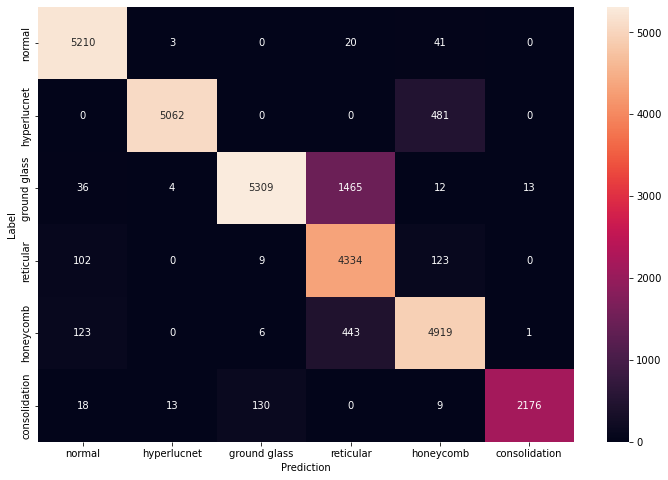

In [15]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)
n_per_class = cf_matrix.numpy().sum(axis=1)
tp_plus_fp_per_class = cf_matrix.numpy().sum(axis=0)
tp_per_class = tf.linalg.diag_part(cf_matrix).numpy()
fp_per_class = tp_plus_fp_per_class - tp_per_class
fn_per_class = n_per_class - tp_per_class
# tn_per_class = tp_per_class.sum() - tp_per_class
tn_per_class = cf_matrix.numpy().sum() - tp_per_class - fp_per_class - fn_per_class
# acc_per_class = tp_per_class / n_per_class
acc_per_class = (tp_per_class+tn_per_class) / (tp_per_class + fn_per_class + tn_per_class + fp_per_class)
precision_per_class = tp_per_class / tp_plus_fp_per_class
recall_per_class = tp_per_class / (tp_per_class + fn_per_class)
f1_per_class = 2*((precision_per_class * recall_per_class))/ (precision_per_class + recall_per_class)
specificity_per_class = tn_per_class / (tn_per_class + fp_per_class) 
ba_acc_per_class = (specificity_per_class + recall_per_class) / 2




In [16]:
data = {
    '': ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation', 'macro-avg', 'micro-avg'],
    'accuracy_valid': acc_per_class.tolist() + [acc_per_class.mean(), results[2]],
    'ba_accuracy_valid': ba_acc_per_class.tolist() + [ba_acc_per_class.mean(), '-'],
    'sensitivity_valid': recall_per_class.tolist() + [recall_per_class.mean(), results[3]],
    'precision_valid': precision_per_class.tolist() + [precision_per_class.mean(), results[2]],
    'specificity_valid': specificity_per_class.tolist() + [specificity_per_class.mean(), '-'],
    'F1_valid': f1_per_class.tolist() + [f1_per_class.mean(), results[1].mean()],
}
df = pd.DataFrame(data=data)
df.style \
    .set_properties(**{
        'text-align': 'center', 
        'width': '120px',
        'font-size': '14px',
        'precision':3
    }) \
    .set_precision(3)

#### Performance metrics
$$\text{accuracy} = \frac{\text{true positives}+ \text{true negatives}}{\text{true positives}+ \text{false negatives} + + \text{true negatives}+\text{false negatives}}$$

$$\text{balanced accuracy} = \frac{\text{specificity} + \text{sensitivity} }{\text{2} }$$

$$\text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positive}}$$

$$\text{sensitivity} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$\text{specificity} = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

$$\text{F1} = 2.\frac{\text{recall} * \text{precision} }{\text{recall + precision} }$$


## Test data

In [17]:
test_dataset = load_batch_dataset(epoch,
                                  batch_size,
                                  out_test_ffname,
                                  vocab,
                                  n_classes,
                                  aug = False,
                                  train=False,
                                 normalize= True)
print(f'nm of test samples: {count_tfrecord_examples(out_test_ffname)}')
print(test_dataset.element_spec)

validation_array = np.array(list(test_dataset.unbatch().take(-1).as_numpy_iterator()))
test_x = np.stack(validation_array[:,0])
test_y = np.stack(validation_array[:,1])
print(test_x.shape, test_y.shape)

test_lbls_pred = np.argmax(model.predict(test_x), axis=1)
test_lbls_gt =  np.argmax((test_y), axis=1)

nm of test samples: 21235
(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))
(21235, 32, 32, 1) (21235, 6)


In [18]:
metrics = [
    F1Score(n_classes, name='F1'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
#compile model
model.compile(optimizer='adam',
               loss= 'categorical_crossentropy',
#                loss=SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO),
               metrics=metrics)
results = model.evaluate(test_dataset, batch_size=batch_size)

166/166 [==============================] - 1s 5ms/step - loss: 0.7226 - F1: 0.7153 - accuracy: 0.7478 - precision: 0.7631 - recall: 0.7277 - auc: 0.9520 - prc: 0.7902


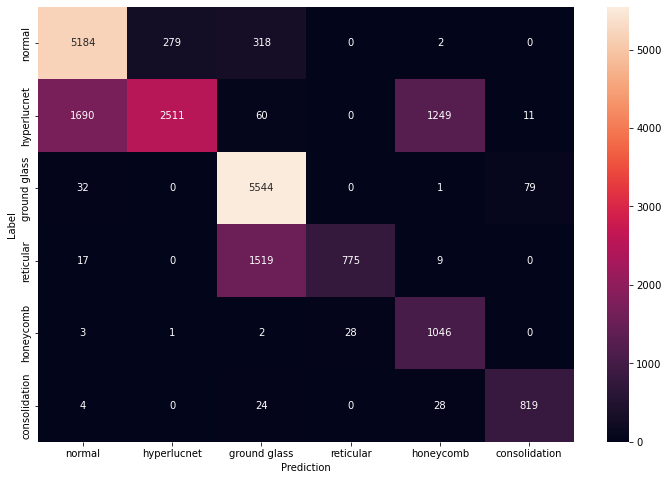

In [19]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)
n_per_class = cf_matrix.numpy().sum(axis=1)
tp_plus_fp_per_class = cf_matrix.numpy().sum(axis=0)
tp_per_class = tf.linalg.diag_part(cf_matrix).numpy()
fp_per_class = tp_plus_fp_per_class - tp_per_class
fn_per_class = n_per_class - tp_per_class
# tn_per_class = tp_per_class.sum() - tp_per_class
tn_per_class = cf_matrix.numpy().sum() - tp_per_class - fp_per_class - fn_per_class
# acc_per_class = tp_per_class / n_per_class
acc_per_class = (tp_per_class+tn_per_class) / (tp_per_class + fn_per_class + tn_per_class + fp_per_class)
precision_per_class = tp_per_class / tp_plus_fp_per_class
recall_per_class = tp_per_class / (tp_per_class + fn_per_class)
specificity_per_class = tn_per_class / (tn_per_class + fp_per_class) 
ba_acc_per_class = (specificity_per_class + recall_per_class) / 2
data = {
    '': ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation', 'macro-avg', 'micro-avg'],
    'accuracy_test': acc_per_class.tolist() + [acc_per_class.mean(), results[2]],
    'ba_accuracy_test': ba_acc_per_class.tolist() + [ba_acc_per_class.mean(), '-'],
    'sensitivity_test': recall_per_class.tolist() + [recall_per_class.mean(), results[3]],
    'precision_test': precision_per_class.tolist() + [precision_per_class.mean(), results[2]],
    'specificity_test': specificity_per_class.tolist() + [specificity_per_class.mean(), '-'],
    'F1_test': f1_per_class.tolist() + [f1_per_class.mean(), results[1].mean()],
}
df = pd.DataFrame(data=data)
df.style \
    .set_properties(**{
        'text-align': 'center', 
        'width': '120px',
        'font-size': '16px',
        'precision':3
    }) \
    .set_precision(3)


In [ ]:
# run_label_ct_lungs -i /home/ubuntu/project/lta/data/dev/train/input/complete/consolidation-000082-Joe_reviewed_1-992-o /home/ubuntu/project/lta/data/dev/train/input/complete/consolidation-000082-Joe_reviewed_1-992/segres --cohort airspace-disease